# Nearest neighbour analysis

ADD IMAGE ABOUT THE BASIC IDEA OF NEAREST NEIGHBOR!

One commonly used GIS task is to be able to find the nearest neighbour for an object or a set of objects. For instance, you might have a single Point object
representing your home location, and then another set of locations representing e.g. public transport stops. Then, quite typical question is *"which of the stops is closest one to my home?"*
This is a typical nearest neighbour analysis, where the aim is to find the closest geometry to another geometry.

In Python this kind of analysis can be done with shapely function called ``nearest_points()`` that [returns a tuple of the nearest points in the input geometries](https://shapely.readthedocs.io/en/latest/manual.html#shapely.ops.nearest_points).

### Nearest point using Shapely

Let's start by testing how we can find the nearest Point using the ``nearest_points()`` function of Shapely.

- Let's create an origin Point and a few destination Points and find out the closest destination:

<!-- #endregion -->

In [1]:
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points

# Origin point
orig = Point(1, 1.67)

# Destination points
dest1 = Point(0, 1.45)
dest2 = Point(2, 2)
dest3 = Point(0, 2.5)

To be able to find out the closest destination point from the origin, we need to create a MultiPoint object from the destination points.

In [2]:
destinations = MultiPoint([dest1, dest2, dest3])
print(destinations)

MULTIPOINT (0 1.45, 2 2, 0 2.5)


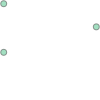

In [3]:
destinations

_**Figure 6.37**. ADD PROPER FIGURE CAPTION!._

Okey, now we can see that all the destination points are represented as a single MultiPoint object.

- Now we can find out the nearest destination point by using ``nearest_points()`` function:


In [4]:
nearest_geoms = nearest_points(orig, destinations)

- We can check the data type of this object and confirm that the ``nearest_points()`` function returns a tuple of nearest points:

In [5]:
type(nearest_geoms)

tuple

 - let's check the contents of this tuple:

In [6]:
print(nearest_geoms)

(<POINT (1 1.67)>, <POINT (0 1.45)>)


In [7]:
print(nearest_geoms[0])

POINT (1 1.67)


In [8]:
print(nearest_geoms[1])

POINT (0 1.45)


In the tuple, the first item (at index 0) is the geometry of our origin point and the second item (at index 1) is the actual nearest geometry from the destination points. Hence, the closest destination point seems to be the one located at coordinates (0, 1.45).

This is the basic logic how we can find the nearest point from a set of points.

### Nearest points using Geopandas

Let's then see how it is possible to find nearest points from a set of origin points to a set of destination points using GeoDataFrames. Here, we will use the ``PKS_suuralueet.kml`` district data, and the ``addresses.shp`` address points from previous sections. 

**Our goal in this tutorial is to find out the closest address to the centroid of each district.**

- Let's first read in the data and check their structure:

In [9]:
import os

os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd
import fiona

In [10]:
# Define filepaths
fp1 = "data/Helsinki/PKS_suuralue.kml"
fp2 = "data/Helsinki/addresses.shp"

In [11]:
# Enable KML driver
fiona.supported_drivers["KML"] = "rw"

In [12]:
# Read in data with geopandas
df1 = gpd.read_file(fp1, driver="KML")
df2 = gpd.read_file(fp2)

In [13]:
# District polygons:
df1.head()

,Name,Description,geometry
0,Suur-Espoonlahti,,"POLYGON Z ((24.77506 60.10906 0.00000, 24.7766..."
1,Suur-Kauklahti,,"POLYGON Z ((24.61578 60.17257 0.00000, 24.6155..."
2,Vanha-Espoo,,"POLYGON Z ((24.67576 60.21201 0.00000, 24.6752..."
3,Pohjois-Espoo,,"POLYGON Z ((24.76792 60.26920 0.00000, 24.7699..."
4,Suur-Matinkylä,,"POLYGON Z ((24.75361 60.16631 0.00000, 24.7537..."


In [14]:
# Address points:
df2.head()

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93166 60.16905)
2,"Bangkok9, 8, Kaivokatu, Keskusta, Kluuvi, Etel...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94168 60.16996)
3,"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.97865 60.19005)
4,"9, Tyynenmerenkatu, Jätkäsaari, Länsisatama, E...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92151 60.15662)


Before calculating any distances, we should re-project the data into a projected crs.

In [15]:
df1 = df1.to_crs(epsg=3067)
df2 = df2.to_crs(epsg=3067)

Furthermore, let's calculate the centroids for each district area:

In [16]:
df1["centroid"] = df1.centroid
df1.head()

,Name,Description,geometry,centroid
0,Suur-Espoonlahti,,"POLYGON Z ((376322.317 6665639.417 0.000, 3764...",POINT (375676.529 6658405.261)
1,Suur-Kauklahti,,"POLYGON Z ((367726.077 6673018.023 0.000, 3677...",POINT (365520.906 6675893.101)
2,Vanha-Espoo,,"POLYGON Z ((371207.712 6677289.881 0.000, 3711...",POINT (367400.175 6681941.088)
3,Pohjois-Espoo,,"POLYGON Z ((376528.523 6683480.345 0.000, 3766...",POINT (372191.037 6687785.458)
4,Suur-Matinkylä,,"POLYGON Z ((375347.271 6672052.630 0.000, 3753...",POINT (375678.189 6670243.076)


SO, for each row of data in the disctricts -table, we want to figure out the nearest address point and fetch some attributes related to that point. In other words, we want to apply the Shapely `nearest_points`function so that we compare each polygon centroid to all address points, and based on this information access correct attribute information from the address table. 

For doing this, we can create a function that we will apply on the polygon GeoDataFrame:

In [17]:
def get_nearest_values(
    row, other_gdf, point_column="geometry", value_column="geometry"
):
    """Find the nearest point and return the corresponding value from specified value column."""

    # Create an union of the other GeoDataFrame's geometries:
    other_points = other_gdf["geometry"].unary_union

    # Find the nearest points
    nearest_geoms = nearest_points(row[point_column], other_points)

    # Get corresponding values from the other df
    nearest_data = other_gdf.loc[other_gdf["geometry"] == nearest_geoms[1]]

    nearest_value = nearest_data[value_column].values[0]

    return nearest_value

By default, this function returns the geometry of the nearest point for each row. It is also possible to fetch information from other columns by changing the `value_column` parameter.

The function creates a MultiPoint object from `other_gdf` geometry column (in our case, the address points) and further passes this MultiPoint object to Shapely's `nearest_points` function. 

Here, we are using a method for creating an union of all input geometries called `unary_union`. 

- Let's check how unary union works by applying it to the address points GeoDataFrame:

In [18]:
unary_union = df2.unary_union
print(unary_union)

MULTIPOINT (381504.3527144172 6678280.815110135, 381880.4108452512 6681202.537438168, 382062.9450822329 6678092.844435816, 382356.2866993041 6679804.21887963, 382745.2925349261 6678996.642557419, 383326.41467843635 6677463.572679194, 384320.89827964845 6671412.394772961, 384618.5735139819 6670910.761284161, 384628.0053863959 6670669.311196408, 385148.814103762 6671753.98966218, 385234.5706753098 6672035.18146947, 385315.3532032097 6672037.488103471, 385486.63769903884 6675317.531513785, 385793.76212730055 6672119.786274237, 385932.252561719 6672267.199839078, 386100.1179494156 6672326.634806169, 386262.03063882986 6673161.263720017, 386323.7502928812 6677878.715123225, 386931.4983202177 6674095.571714901, 387320.8120850853 6678704.464068138, 387912.71703988867 6674292.27520661, 388924.30183989904 6680234.979897246, 389469.4416996006 6674096.854469957, 390019.02803467 6681029.072559796, 390419.00094183 6680179.263382102, 390681.0602651929 6674696.071671507, 390930.6812250181 6682408.474

Okey now we are ready to use our function and find closest address point for each polygon centroid.
 - Try first applying the function without any additional modifications: 

In [19]:
df1["nearest_loc"] = df1.apply(
    get_nearest_values, other_gdf=df2, point_column="centroid", axis=1
)

- Finally, we can specify that we want the `id` -column for each point, and store the output in a new column `"nearest_loc"`:

In [20]:
df1["nearest_loc"] = df1.apply(
    get_nearest_values,
    other_gdf=df2,
    point_column="centroid",
    value_column="id",
    axis=1,
)

In [21]:
df1.head()

,Name,Description,geometry,centroid,nearest_loc
0,Suur-Espoonlahti,,"POLYGON Z ((376322.317 6665639.417 0.000, 3764...",POINT (375676.529 6658405.261),1005
1,Suur-Kauklahti,,"POLYGON Z ((367726.077 6673018.023 0.000, 3677...",POINT (365520.906 6675893.101),1020
2,Vanha-Espoo,,"POLYGON Z ((371207.712 6677289.881 0.000, 3711...",POINT (367400.175 6681941.088),1017
3,Pohjois-Espoo,,"POLYGON Z ((376528.523 6683480.345 0.000, 3766...",POINT (372191.037 6687785.458),1017
4,Suur-Matinkylä,,"POLYGON Z ((375347.271 6672052.630 0.000, 3753...",POINT (375678.189 6670243.076),1000


That's it! Now we found the closest point for each centroid and got the ``id`` value from our addresses into the ``df1`` GeoDataFrame.

## Nearest neighbor analysis with large datasets

While Shapely's `nearest_points` -function provides a nice and easy way of conducting the nearest neighbor analysis, it can be quite slow. Using it also requires taking the `unary union` of the point dataset where all the Points are merged into a single layer. This can be a really memory hungry and slow operation, that can cause problems with large point datasets.  

Luckily, there is a much faster and memory efficient alternatives for conducting nearest neighbor analysis, based on a function called [BallTree](https://en.wikipedia.org/wiki/Ball_tree) from a [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html) library. The Balltree algorithm has some nice features, such as the ability to calculate the distance between neighbors with various different distance metrics. Most importantly the function allows to calculate `euclidian` distance between neighbors (good if your data is in metric crs), as well as `haversine` distance which allows to determine [Great Circle distances](https://en.wikipedia.org/wiki/Great-circle_distance) between locations (good if your data is in lat/lon format). *Note: There is also an algorithm called [KDTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree) in scikit-learn, that is also highly efficient but less flexible in terms of supported distance metrics.* 

### Motivation

In this tutorial, we go through a very practical example that relates to our daily commute: Where is the closest public transport stop from my place of living? Hence, our aim is to search for each building in Helsinki Region (around 159 000 buildings) the closest public transport stop (~ 8400 stops). The building points have been fetched from OpenStreetMap using a library called [OSMnx](https://github.com/gboeing/osmnx) (we will learn more about this library later), and the public transport stops have been fetched from open [GTFS dataset for Helsinki Region](https://transitfeeds.com/p/helsinki-regional-transport/735) that contains information about public transport stops, schedules etc. 

### Efficient nearest neighbor search with Geopandas and scikit-learn

The following examples show how to conduct nearest neighbor analysis efficiently with large datasets. We will first define the functions and see how to use them, and then we go through the code to understand what happened.

- Let's first read the datasets into Geopandas. In case of reading the building data, we will here learn a trick how to read the data directly from a ZipFile. It is very practical to know how to do this, as compressing large datasets is a very common procedure.

In [22]:
import geopandas as gpd
from zipfile import ZipFile
import io


def read_gdf_from_zip(zip_fp):
    """
    Reads a spatial dataset from ZipFile into GeoPandas. Assumes that there is only a single file (such as GeoPackage)
    inside the ZipFile.
    """
    with ZipFile(zip_fp) as z:
        # Lists all files inside the ZipFile, here assumes that there is only a single file inside
        layer = z.namelist()[0]
        data = gpd.read_file(io.BytesIO(z.read(layer)))
    return data


# Filepaths
stops = gpd.read_file("data/Helsinki/pt_stops_helsinki.gpkg")
buildings = read_gdf_from_zip("data/Helsinki/building_points_helsinki.zip")

- Let's see how our datasets look like:

In [23]:
print(buildings.head(), "\n--------")
print(stops.head())

             name                   geometry
0             NaN  POINT (24.85584 60.20727)
1     Uimastadion  POINT (24.93045 60.18882)
2             NaN  POINT (24.95113 60.16994)
3  Hartwall Arena  POINT (24.92918 60.20570)
4           Talli  POINT (24.92607 60.21346) 
--------
     stop_name   stop_lat   stop_lon  stop_id                   geometry
0  Ritarihuone  60.169460  24.956670  1010102  POINT (24.95667 60.16946)
1   Kirkkokatu  60.171270  24.956570  1010103  POINT (24.95657 60.17127)
2   Kirkkokatu  60.170293  24.956721  1010104  POINT (24.95672 60.17029)
3    Vironkatu  60.172580  24.956554  1010105  POINT (24.95655 60.17258)
4    Vironkatu  60.172990  24.956380  1010106  POINT (24.95638 60.17299)


Okay, so both of our datasets consisting points, and based on the coordinates, they seem to be in WGS84 projection.

- Let's also make maps out of them to get a better understanding of the data

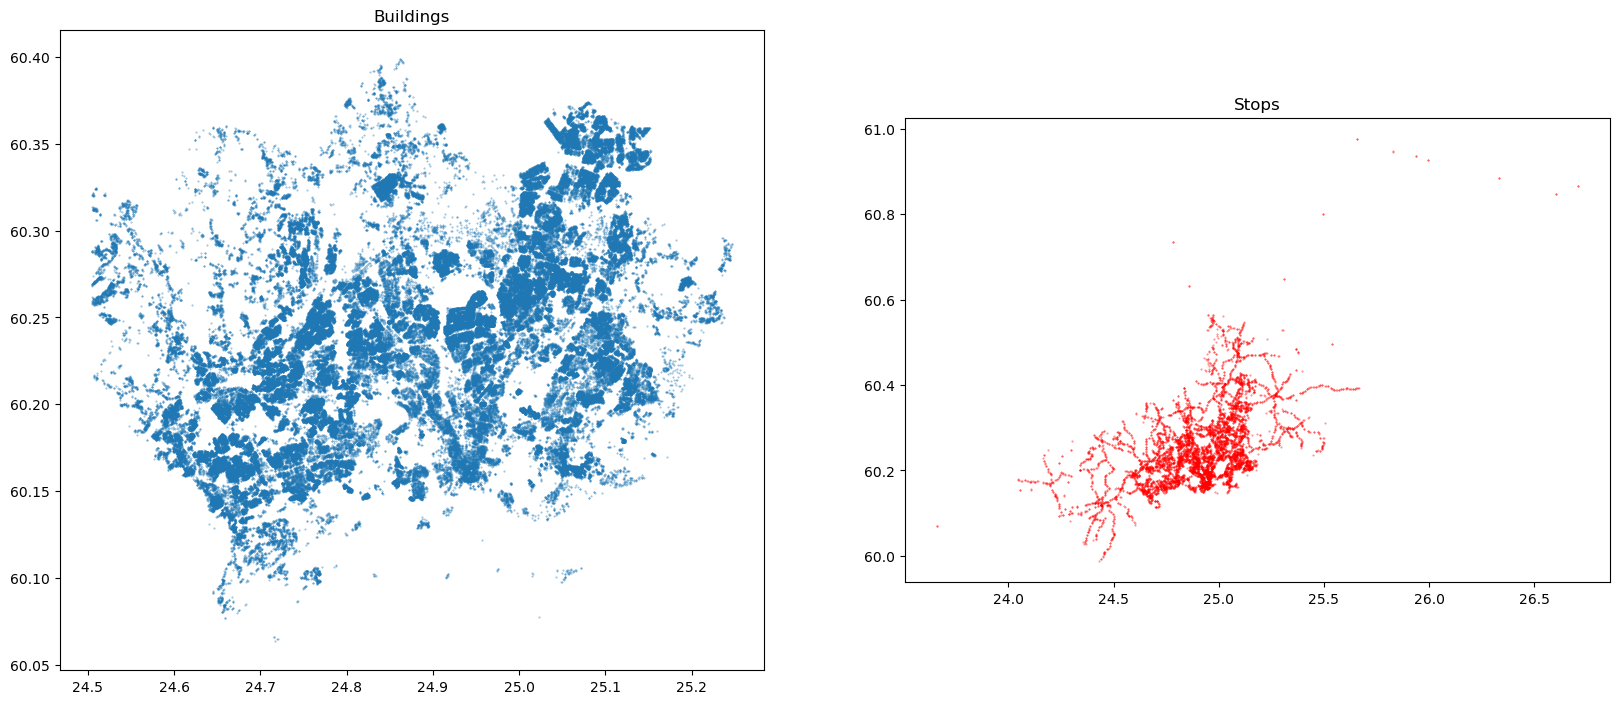

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Plot buildings
buildings.plot(ax=axes[0], markersize=0.2, alpha=0.5)
axes[0].set_title("Buildings")

# Plot stops
stops.plot(ax=axes[1], markersize=0.2, alpha=0.5, color="red")
axes[1].set_title("Stops");

_**Figure 6.38**. ADD PROPER FIGURE CAPTION!._

As we can see, we have a very densely distributed Point dataset that shows the location of the buildings (their centroid) in Helsinki Region. On the right, we have public transport stops that seem to cover a bit broader geographical extent with a few train stops reaching further North. Most importantly, we can see from the coordinates and the map that both of the layers share the same coordinate reference system, and they are approximately from the same geographical region. Hence, we are ready to find closest public transport stop (on the right) for each building on the left map.     

- Let's first prepare a couple of functions that does the work

In [25]:
from sklearn.neighbors import BallTree
import numpy as np


def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric="haversine")

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.

    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """

    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)

    # Parse coordinates from points and insert them into a numpy array as RADIANS
    # Notice: should be in Lat/Lon format
    left_radians = np.array(
        left_gdf[left_geom_col]
        .apply(lambda geom: (geom.y * np.pi / 180, geom.x * np.pi / 180))
        .to_list()
    )
    right_radians = np.array(
        right[right_geom_col]
        .apply(lambda geom: (geom.y * np.pi / 180, geom.x * np.pi / 180))
        .to_list()
    )

    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)

    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]

    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points["distance"] = dist * earth_radius

    return closest_points

Okay, now we have our functions defined. So let's use them and find the nearest neighbors!

In [26]:
# Find closest public transport stop for each building and get also the distance based on haversine distance
# Note: haversine distance which is implemented here is a bit slower than using e.g. 'euclidean' metric
# but useful as we get the distance between points in meters
closest_stops = nearest_neighbor(buildings, stops, return_dist=True)

# And the result looks like ..
closest_stops

,stop_name,stop_lat,stop_lon,stop_id,geometry,distance
0,Muusantori,60.20749,24.857450,1304138,POINT (24.85745 60.20749),92.374498
1,Auroran sairaala,60.19145,24.925540,1171122,POINT (24.92554 60.19145),399.238170
2,Senaatintori,60.16901,24.950460,1020450,POINT (24.95046 60.16901),109.608289
3,Veturitie,60.20661,24.929680,1174112,POINT (24.92968 60.20661),104.437950
4,Posti 1,60.21345,24.917550,1172143,POINT (24.91755 60.21345),470.640839
...,...,...,...,...,...,...
158726,Samis,60.21369,24.720970,3170209,POINT (24.72097 60.21369),195.069355
158727,Yrjö Liipolan tie,60.20922,24.695470,3170244,POINT (24.69547 60.20922),136.666774
158728,Kandidaatintie,60.21818,24.736987,3170245,POINT (24.73699 60.21818),135.041718
158729,Uimahalli,60.21638,24.711260,3170212,POINT (24.71126 60.21638),99.078476


Great, that didn't take too long! Especially considering that we had quite a few points in our datasets (8400\*159000=1.33 billion connections). As a result, we have a new GeoDataFrame that reminds a lot the original `stops` dataset. However, as we can see there are much more rows than in the original dataset, and in fact, each row in this dataset corresponds to a single building in the `buildings` dataset. Hence, we should have exactly the same number of closest_stops as there are buildings. Let's confirm this: 

In [27]:
# Now we should have exactly the same number of closest_stops as we have buildings
print(len(closest_stops), "==", len(buildings))

158731 == 158731


Indeed, that seems to be the case. Hence, it is easy to combine these two datasets together. Before continuing our analysis, let's take a bit deeper look, what we actually did with the functions above.  

### What did we just do? Explanation.

To get a bit more understanding of what just happened, let's go through the essential parts of the two functions we defined earlier, i.e. `nearest_neighbor()` and `get_closest()`.

The purpose of `nearest_neighbor()` function is to handle and transform the data from GeoDataFrame into `numpy arrays` (=super-fast data structure) in a format how `BallTree` function wants them. This includes converting the lat/lon coordinates into radians (and back), so that we get the distances between the neighboring points in a correct format: scikit-learn's [haversine distance metric](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html) wants inputs as radians and also outputs the data as radians. To convert a lat/lon coordinate to radian, we use formula: `Radian = Degree * PI / 180`. By doing this, we are able to get the output distance information in meters (even if our coordinates are in decimal degrees). 

The `get_closest()` function does the actual nearest neighbor search using [BallTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html) function. We initialize the `BallTree` object with the coordinate information from the **right_gdf** (i.e. the point dataset that contains all the nearest neighbor candidates), and we specify the distance metric to be `haversine` so that we get the Great Circle Distances. The `leaf_size` parameter adjusts the tradeoff between the cost of BallTree node traversal and the cost of a brute-force distance estimate. Changing leaf_size will not affect the results of a query, but can significantly impact the speed of a query and the memory required to store the constructed tree. We determine the leaf_size as 15 which has been found to be a good compromise when [benchmarked](https://jakevdp.github.io/blog/2013/04/29/benchmarking-nearest-neighbor-searches-in-python/). After we have built (initialized) the ball-tree, we run the nearest neighbor query with `tree.query(src_points, k=k_neighbors)`, where the src_points are the building-coordinates (as radians) and the `k` -parameter is the number of neighbors we want to calculate (1 in our case as we are only interested in the closest neighbor). Finally, we just re-arrange the data back into a format in which the closest point indices and distances are in separate numpy arrays. 

**Note:** The functions here assume that your input points are in WGS84 projection. If you pass the points in some other projection, it is highly likely that the distances between nearest neighbors are incorrect. Determining which is the nearest neighbor should not be affected, though.  

### Combining the neighboring datasets 

Okay, now as we have found closest stop for each building in the region, we can easily merge the information about closest stops back to the building layer. The order of the `closest_stops` matches exactly the order in `buildings`, so we can easily merge the datasets based on index. 

In [28]:
# Rename the geometry of closest stops gdf so that we can easily identify it
closest_stops = closest_stops.rename(columns={"geometry": "closest_stop_geom"})

# Merge the datasets by index (for this, it is good to use '.join()' -function)
buildings = buildings.join(closest_stops)

# Let's see what we have
buildings.head()

,name,geometry,stop_name,stop_lat,stop_lon,stop_id,closest_stop_geom,distance
0,NaN,POINT (24.85584 60.20727),Muusantori,60.20749,24.85745,1304138,POINT (24.85745 60.20749),92.374498
1,Uimastadion,POINT (24.93045 60.18882),Auroran sairaala,60.19145,24.92554,1171122,POINT (24.92554 60.19145),399.238170
2,NaN,POINT (24.95113 60.16994),Senaatintori,60.16901,24.95046,1020450,POINT (24.95046 60.16901),109.608289
3,Hartwall Arena,POINT (24.92918 60.20570),Veturitie,60.20661,24.92968,1174112,POINT (24.92968 60.20661),104.437950
4,Talli,POINT (24.92607 60.21346),Posti 1,60.21345,24.91755,1172143,POINT (24.91755 60.21345),470.640839


Excellent! Now we have useful information for each building about the closest stop including the `distance` (in meters) and also e.g. the name of the stop in `stop_name` column. 

- Now it is easy to do some descriptive analysis based on this dataset, that gives information about levels of access to public transport in the region: 

In [29]:
buildings["distance"].describe()

count    158731.000000
mean        228.708617
std         292.312344
min           0.741216
25%          99.641666
50%         163.507667
75%         259.826284
max        7684.884105
Name: distance, dtype: float64

Okay, as we can see the average distance to public transport in the region is around 300 meters. More than 75 % of the buildings seem to be within within 5 minute walking time (~370 meters with walking speed of 4.5 kmph) which indicates generally a good situation in terms of accessibility levels in the region overall. There seem to be some really remote buildings in the data as well, as the longest distance to closest public transport stop is more than 7 kilometers.

- Let's make a map out of the distance information to see if there are some spatial patterns in the data in terms of accessibility levels:

<AxesSubplot: >

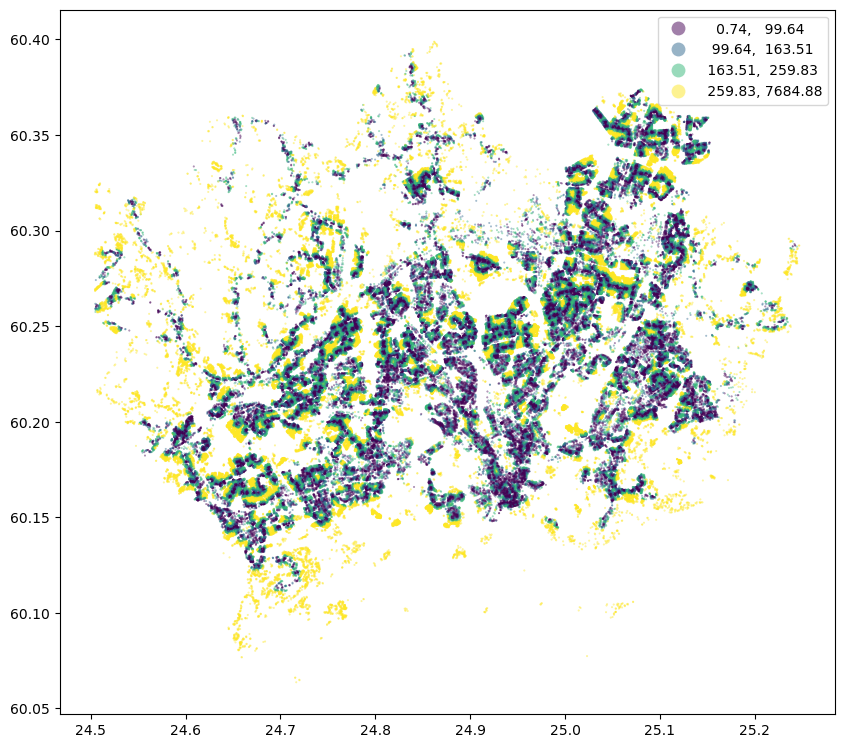

In [30]:
buildings.plot(
    column="distance",
    markersize=0.2,
    alpha=0.5,
    figsize=(10, 10),
    scheme="quantiles",
    k=4,
    legend=True,
)

_**Figure 6.39**. ADD PROPER FIGURE CAPTION!._

Okay, as we can see, there are some clear spatial patterns in the levels of access to public transport. The buildings with the shortest distances (i.e. best accessibility) are located in the densely populated areas, whereas the buildings locating in the periferial areas (such as islands on the South, and nature areas in the North-West) tend to have longer distance to public transport. 

### Are the results correct? Validation

As a final step, it's good to ensure that our functions are working as they should. This can be done easily by examining the data visually.

- Let's first create LineStrings between the building and closest stop points:

In [31]:
from shapely.geometry import LineString

# Create a link (LineString) between building and stop points
buildings["link"] = buildings.apply(
    lambda row: LineString([row["geometry"], row["closest_stop_geom"]]), axis=1
)

# Set link as the active geometry
building_links = buildings.copy()
building_links = building_links.set_geometry("link")

- Let's now visualize the building points, stops and the links, and zoom to certain area so that we can investigate the results, and confirm that everything looks correct.

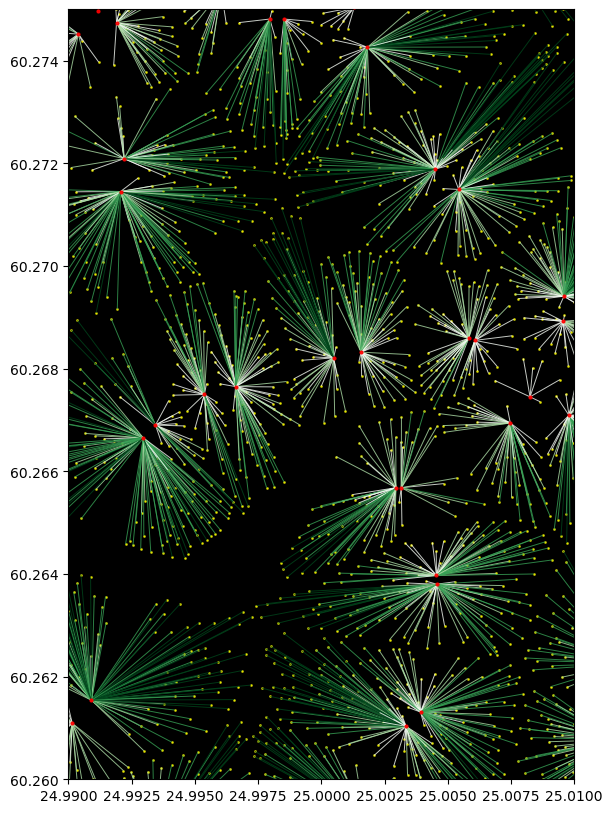

In [32]:
# Plot the connecting links between buildings and stops and color them based on distance
ax = building_links.plot(
    column="distance",
    cmap="Greens",
    scheme="quantiles",
    k=4,
    alpha=0.8,
    lw=0.7,
    figsize=(13, 10),
)
ax = buildings.plot(ax=ax, color="yellow", markersize=1, alpha=0.7)
ax = stops.plot(ax=ax, markersize=4, marker="o", color="red", alpha=0.9, zorder=3)

# Zoom closer
ax.set_xlim([24.99, 25.01])
ax.set_ylim([60.26, 60.275])

# Set map background color to black, which helps with contrast
ax.set_facecolor("black")

_**Figure 6.40**. ADD PROPER FIGURE CAPTION!._

Voilá, these weird star looking shapes are formed around public transport stops (red) where each link is associated buildings (yellow points) that are closest to the given stop. The color intensity varies according the distance between the stops and buildings. Based on this figure we can conclude that our nearest neighbor search was succesfull and worked as planned.